In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

from sklearn import linear_model
from sklearn.feature_selection import f_regression, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score

In [2]:
df = pd.read_excel('table_8_offenses_known_to_law_enforcement_california_by_city_2013.xls', header=4)

## Data cleaning

In [3]:
#Cleaning data set for modeling

#removing Nan column
df = df.drop('Rape\n(revised\ndefinition)1', axis=1)

#renaming columns
df.columns = ['City', 'Population', 'Violent', 'Murder', 'Rape', 'Robbery', 'Aggravated assault',
              'Property crime', 'Burglary','Larceny theft', 'Motor vehicle theft', 'Arson']

#Droping Nan rows
df = df.drop([462, 463])

In [4]:
df.head()

,City,Population,Violent,Murder,Rape,Robbery,Aggravated assault,Property crime,Burglary,Larceny theft,Motor vehicle theft,Arson
0,Adelanto,31165.0,198.0,2.0,15.0,52.0,129.0,886.0,381.0,372.0,133.0,17.0
1,Agoura Hills,20762.0,19.0,0.0,2.0,10.0,7.0,306.0,109.0,185.0,12.0,7.0
2,Alameda,76206.0,158.0,0.0,10.0,85.0,63.0,1902.0,287.0,1285.0,330.0,17.0
3,Albany,19104.0,29.0,0.0,1.0,24.0,4.0,557.0,94.0,388.0,75.0,7.0
4,Alhambra,84710.0,163.0,1.0,9.0,81.0,72.0,1774.0,344.0,1196.0,234.0,7.0


In [5]:
df.isnull().sum()

City                   0
Population             0
Violent                0
Murder                 0
Rape                   0
Robbery                0
Aggravated assault     0
Property crime         0
Burglary               0
Larceny theft          0
Motor vehicle theft    0
Arson                  0
dtype: int64

In [6]:
#Droping top 5% of population outliers.
df = df.drop(df[df['Population'] > (df['Population'].quantile(.95))].index)

#Creating a binary murder outcome to test logistic regression.
df['Murder_b'] = np.where(df['Murder'] > 0, 1, 0)

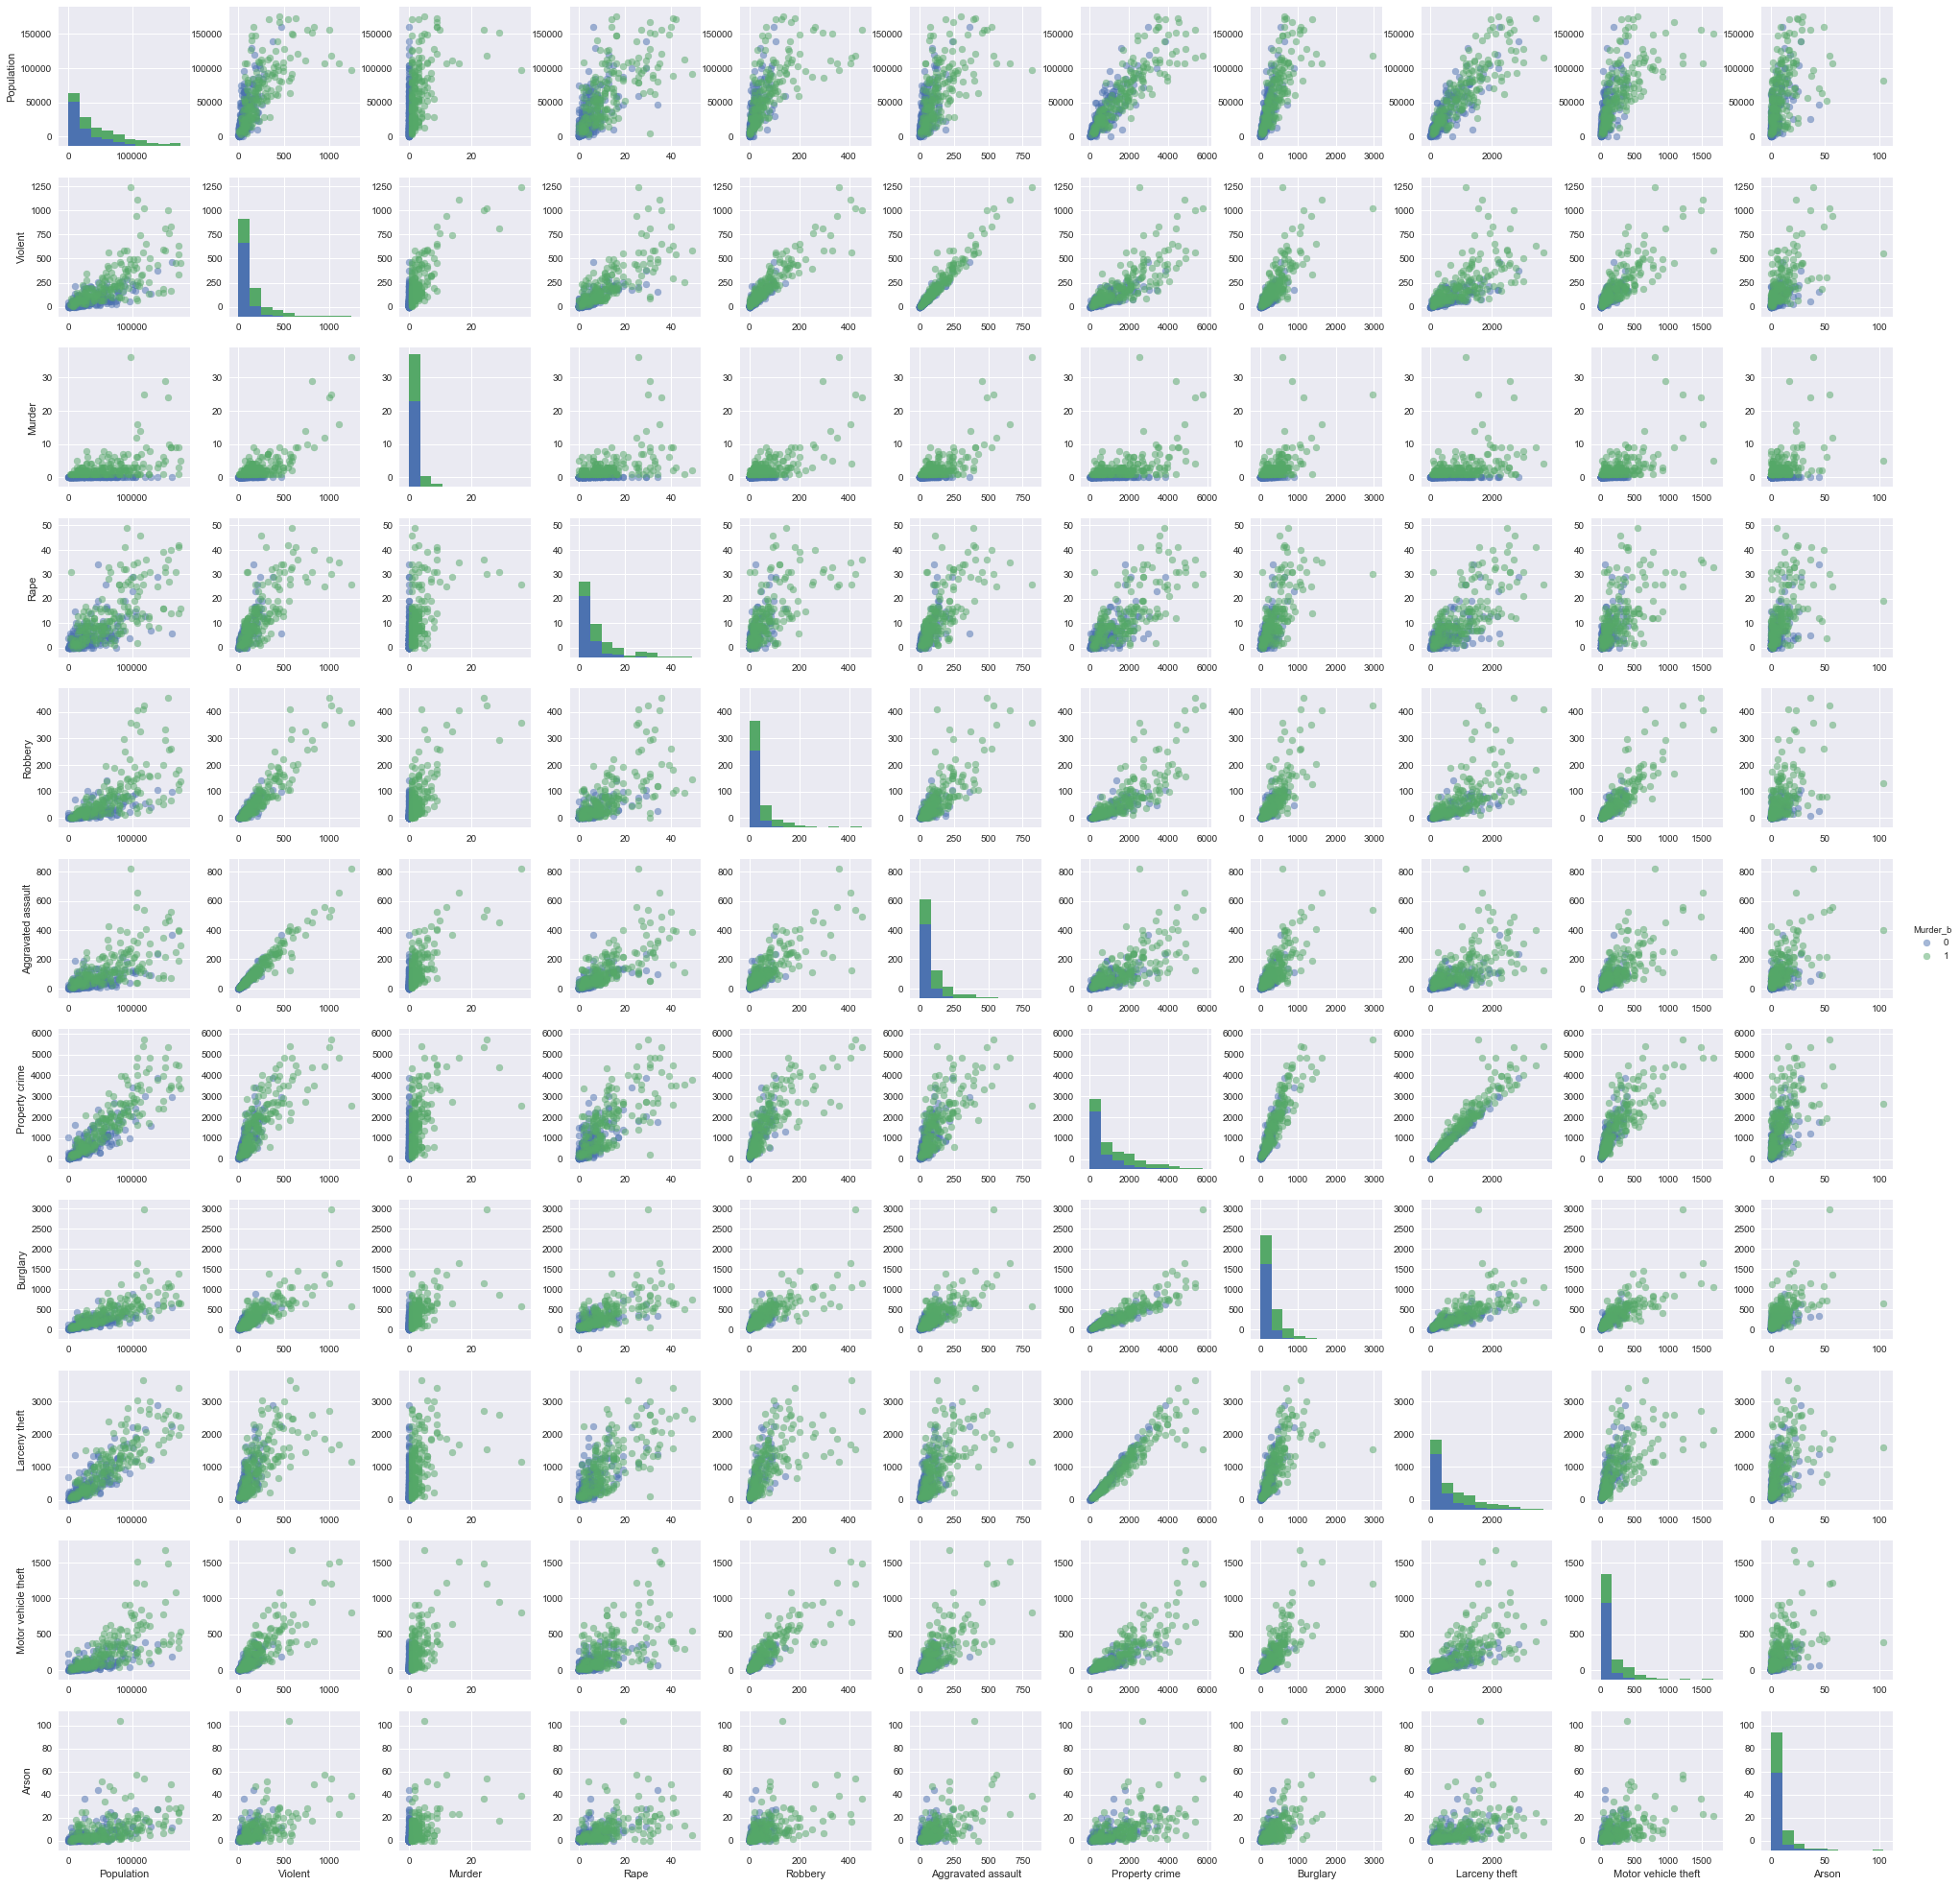

In [7]:
g = sns.PairGrid(df, hue="Murder_b", vars=['Population', 'Violent', 'Murder', 'Rape', 'Robbery', 'Aggravated assault',
              'Property crime', 'Burglary','Larceny theft', 'Motor vehicle theft', 'Arson'])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter, alpha=.5)
g.add_legend();

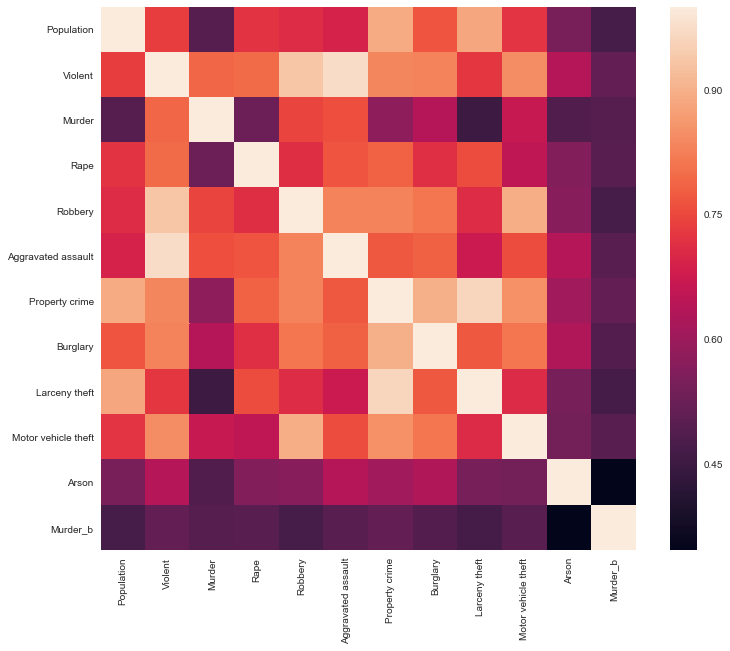

In [8]:
plt.subplots(figsize=(12,10)) 
sns.heatmap(df.corr())
plt.show()

## Feature engineering

standardizing independent variables because the magnitude of population is much larger then our other variables.

In [9]:
df.dtypes

City                    object
Population             float64
Violent                float64
Murder                 float64
Rape                   float64
Robbery                float64
Aggravated assault     float64
Property crime         float64
Burglary               float64
Larceny theft          float64
Motor vehicle theft    float64
Arson                  float64
Murder_b                 int32
dtype: object

In [10]:
independent_vars = ['Population', 'Violent', 'Rape', 'Robbery', 'Aggravated assault',
                    'Property crime', 'Burglary','Larceny theft', 'Motor vehicle theft', 'Arson']

#Working data frame
newdf = df.drop(['City'], 1)

#square transforms on vars
independent_vars_squared = []
for x in independent_vars:
    col_new = x + ' squared'
    independent_vars_squared.append(col_new)
    newdf[col_new] = newdf[x] * newdf[x]

#Standardizing variables because population is much larger then the other variables
scaler = StandardScaler().fit(newdf[newdf.columns.difference(['Murder_b', 'Murder'])])
newdf[newdf.columns.difference(['Murder_b', 'Murder'])] = scaler.transform(newdf[newdf.columns.difference(['Murder_b', 'Murder'])])


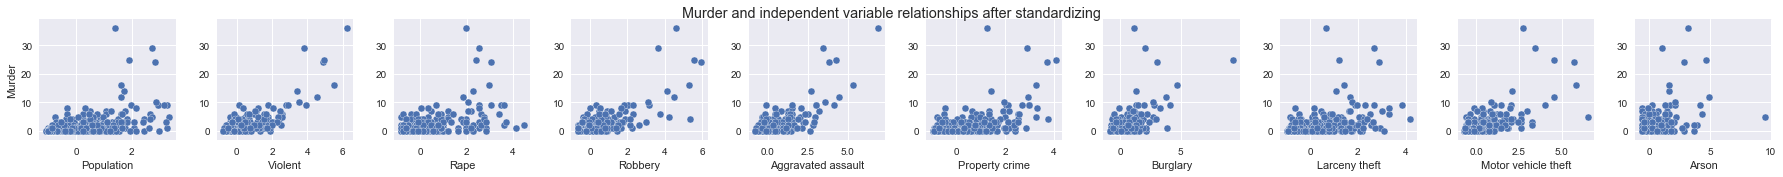

In [11]:
sns.pairplot(data=newdf,
    x_vars=independent_vars,
    y_vars=['Murder'])
plt.suptitle('Murder and independent variable relationships after standardizing')
plt.show()

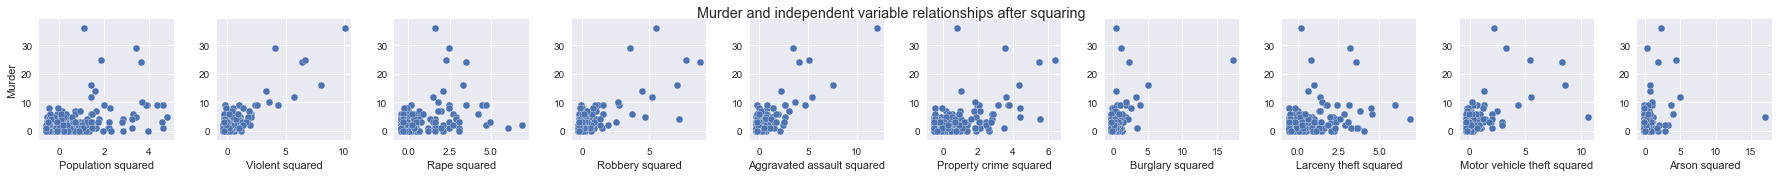

In [12]:
sns.pairplot(data=newdf,
    x_vars=independent_vars_squared,
    y_vars=['Murder'])
plt.suptitle('Murder and independent variable relationships after squaring')
plt.show()

## Logistic regression

In [13]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(C=1e9)
y = newdf['Murder_b']
X = newdf[independent_vars]
fit = lr.fit(X, y)

prediction = lr.predict(X)

print(pd.crosstab(prediction, y))

print('\n Percentage accuracy for each fold')
print(cross_val_score(lr, X, y, cv=10))

Murder_b    0    1
row_0             
0         251    0
1           0  187

 Percentage accuracy for each fold
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [14]:
f_test, p_values = f_classif(X, y)

i = 0
for name in X.columns:
    print(name)
    print('f_test:  {}'.format(f_test[i]))
    print('p_value: {}\n'.format(p_values[i]))
    i += 1

Population
f_test:  121.18185939951728
p_value: 4.90281691972909e-25

Violent
f_test:  154.75206245853008
p_value: 1.2935787489608232e-30

Rape
f_test:  140.8286650352473
p_value: 2.426346941954553e-28

Robbery
f_test:  121.26119118383743
p_value: 4.751794490986999e-25

Aggravated assault
f_test:  141.97223887997228
p_value: 1.570865978740422e-28

Property crime
f_test:  156.586312799786
p_value: 6.552854513419583e-31

Burglary
f_test:  136.7572000965492
p_value: 1.1490137824414963e-27

Larceny theft
f_test:  120.05350954348245
p_value: 7.654695912626617e-25

Motor vehicle theft
f_test:  141.22370721746208
p_value: 2.0877794281747668e-28

Arson
f_test:  59.161311992411505
p_value: 9.762275633902151e-14



100% accuracy is alarming. Violent crime is surprisingly the most significant feature. Our squared features did not perform well, it drops the accuracy by 15%. Going to test model on a new data set to make sure it's not being overfit.

In [15]:
nydf = pd.read_excel('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls', header=4)

In [16]:
#Cleaning

#removing first rape column every entry was NAN
nydf = nydf.drop('Rape\n(revised\ndefinition)1', axis=1)

#removing last three rows, NAN values
nydf = nydf.drop([348,349,350])

#renaming columns
nydf.columns = ['City', 'Population', 'Violent', 'Murder', 'Rape', 'Robbery', 'Aggravated assault',
              'Property crime', 'Burglary','Larceny theft', 'Motor vehicle theft', 'Arson']

#Arson had 161 null values replacing with zero
nydf['Arson'].fillna(0, inplace=True)

#Creating a binary murder outcome to test logistic regression.
nydf['Murder_b'] = np.where(nydf['Murder'] > 0, 1, 0)

#Droping city
nydf = nydf.drop(['City'], 1)

#square transforms on vars
independent_vars_squared = []
for x in independent_vars:
    col_new = x + ' squared'
    independent_vars_squared.append(col_new)
    nydf[col_new] = nydf[x] * nydf[x]

In [17]:
#Executing model

#Applying scaler
nydf[nydf.columns.difference(['Murder_b', 'Murder'])] = scaler.transform(nydf[nydf.columns.difference(['Murder_b', 'Murder'])])

In [18]:
#Setting X and Y
y = nydf['Murder_b']
X = nydf[independent_vars]

prediction = lr.predict(X)

print(pd.crosstab(prediction, y))

Murder_b    0   1
row_0            
0         299   0
1           0  49


Testing the model on a new data set we still get a 100% accuracy. 

## Ridge regression

In [19]:
ridgeregr = linear_model.Ridge(alpha=150) 
y = newdf['Murder']
X = newdf[independent_vars + independent_vars_squared]
ridgeregr.fit(X, y)

prediction = ridgeregr.predict(X)

print(cross_val_score(ridgeregr, X, y, cv=5).mean())

0.570037595866


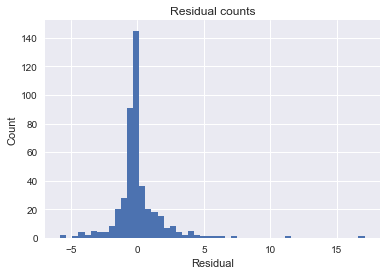

In [20]:
actual = y
predicted = prediction
# Calculate the error, also called the residual.
residual = actual - predicted

plt.hist(residual, bins=50)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

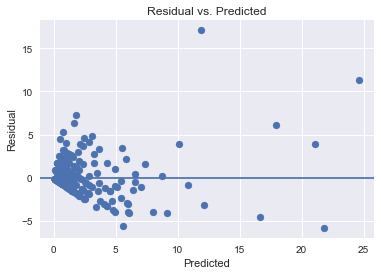

In [21]:
plt.scatter(prediction, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

This model did not turn out well. Residual scatter plot is not desireable, the plot here represents the lack of strong linear relationships. Our squared variables performed well here. Errors are large. Our F-tests are telling us that violent crimes, and aggravated assault are the strongest independent variables, going to try a simple model with those variables.

In [22]:
ridgeregr = linear_model.Ridge(alpha=1) 
y = newdf['Murder']
X = newdf[['Violent squared', 'Aggravated assault squared', 'Robbery squared']]
ridgeregr.fit(X, y)

prediction = ridgeregr.predict(X)

print(cross_val_score(ridgeregr, X, y, cv=5).mean())

0.657805278383


Improved , but still low. The linear relationships aren't strong enough here to predict Murder outcomes/continuous variables, but they worked well for logistic regression/classification. Going to predict property crime because it has stronger relationships.

In [23]:
#Remove transform from new dependent variable
newdf[newdf.columns.difference(['Murder_b', 'Murder'])] = scaler.inverse_transform(newdf[newdf.columns.difference(['Murder_b', 'Murder'])])

#square transforms on vars
independent_vars = ['Population', 'Violent', 'Rape', 'Robbery', 'Aggravated assault',
                    'Murder', 'Burglary','Larceny theft', 'Motor vehicle theft', 'Arson']

independent_vars_squared = []
for x in independent_vars:
    col_new = x + ' squared'
    independent_vars_squared.append(col_new)
    newdf[col_new] = newdf[x] * newdf[x]

#Transform again
scaler = StandardScaler().fit(newdf[newdf.columns.difference(['Murder_b', 'Property crime'])])
newdf[newdf.columns.difference(['Murder_b', 'Property crime'])] = scaler.transform(newdf[newdf.columns.difference(['Murder_b', 'Property crime'])])

In [24]:
ridgeregr = linear_model.Ridge(alpha=5) 
y = newdf['Property crime']
X = newdf[independent_vars]
ridgeregr.fit(X, y)

prediction = ridgeregr.predict(X)

print(cross_val_score(ridgeregr, X, y, cv=5))
print(cross_val_score(ridgeregr, X, y, cv=5).mean())

[ 0.9995675   0.99961621  0.99917194  0.99966822  0.99953878]
0.99951253144


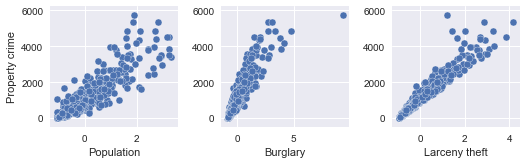

In [25]:
sns.pairplot(data=newdf,
    x_vars=['Population', 'Burglary', 'Larceny theft'],
    y_vars=['Property crime'])
plt.show()

Property Crime was much easier to predict because the linear relationships were much stronger. Our squared variables did not help our accuracy.

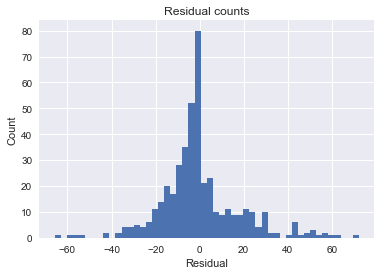

In [26]:
actual = y
predicted = prediction
# Calculate the error, also called the residual.
residual = actual - predicted

plt.hist(residual, bins=50)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

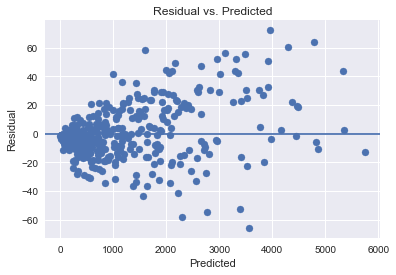

In [27]:
plt.scatter(prediction, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

## LASSO regresion

In [72]:
lass = linear_model.Lasso(alpha=1)
y = newdf['Property crime']
X = newdf[independent_vars + independent_vars_squared]
lassfit = lass.fit(X, y)

prediction = lass.predict(X)

print(cross_val_score(lass, X, y, cv=5))

[ 0.99999919  0.99999897  0.99999922  0.99999856  0.99999867]


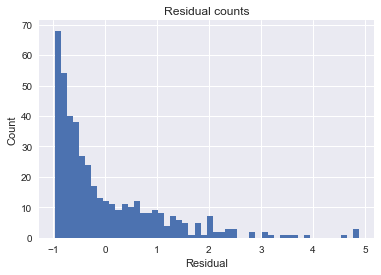

In [73]:
actual = y
predicted = prediction

residual = actual - predicted

plt.hist(residual, bins=50)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

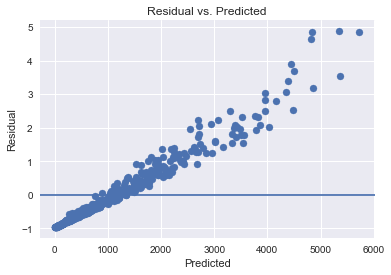

In [74]:
plt.scatter(prediction, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

That's really odd. The regression is not fitting properly.

In [75]:
lass = linear_model.Lasso(alpha=1)
y = newdf['Property crime']
X = newdf[['Population', 'Burglary', 'Larceny theft', 'Population squared', 'Burglary squared', 'Larceny theft squared']]
lassfit = lass.fit(X, y)

prediction = lass.predict(X)

print(cross_val_score(lass, X, y, cv=5))

[ 0.98910749  0.98401955  0.98677702  0.98129041  0.96247389]


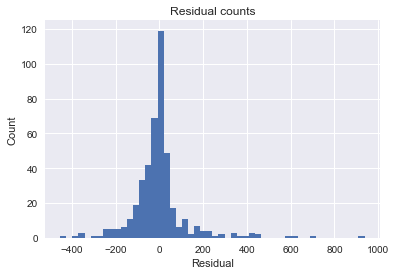

In [76]:
actual = y
predicted = prediction

residual = actual - predicted

plt.hist(residual, bins=50)
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

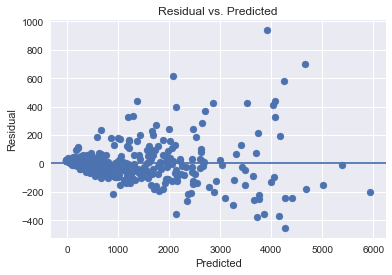

In [77]:
plt.scatter(prediction, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()